In [144]:
#Questions: Are the different coefficients uniform amongst all the nodes in the graph ? Right now, they are equal for all nodes.
#To easily compute and update the happiness, we keep the following properties true during the evolution of the graph:
# - the attribute contains the happiness of the current node at each step
# - at the begining of a step, the attribute 'happiness_updating' contains coeff_X*X + coeff_Z*Z + coeff_previous_happiness*happiness.
#Therefore we only have to add the influence of all the other nodes at 'happiness_updating' to obtain the updated happiness.

#Here, at each step, we choose a random node and add one friend to it. Then update the happiness of everyone.

In [145]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math

In [146]:
#Defining our global variables:
N_nodes = 100

In [147]:
#Defining graph
G=nx.DiGraph()
G.add_nodes_from(range(N_nodes))

In [148]:
#Defining attributes
for i in range(N_nodes):
    G.node[i]['X'] = random.random()
    G.node[i]['Z'] = random.random()
    G.node[i]['coeff_X'] = 1
    G.node[i]['coeff_Z'] = 1
    G.node[i]['coeff_previous_happiness'] = 1
    G.node[i]['coeff_influence'] = 1
    G.node[i]['happiness'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']
    G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness']

In [149]:
#Creating similarity matrix
similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
similarity_coefficient = 3
for i in range(N_nodes):
    for j in range(i):
        similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
        similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
        similarity_matrix[j][i] = similarity_matrix[i][j]

In [150]:
#Creating set of potential friends for each node
list_potential_friends = [[] for i in range(N_nodes)]
for i in range(N_nodes):
    for j in range(N_nodes):
        if i != j:
            if random.random() < similarity_matrix[i][j]:
                list_potential_friends[i].append(j)

In [151]:
#Function to add to the node "node" a random friend from his list of friends (and to remove him from the list)
def add_one_friend(node, Graph):
    new_friend = random.choice(list_potential_friends[node])
    list_potential_friends[node].remove(new_friend)
    Graph.add_edge(node, new_friend)

In [152]:
#This step is made to add a friend for each node of the Graph
def init_step(Graph):
    for node in range(N_nodes):
        add_one_friend(node, Graph)

In [153]:
#Update happiness 
def update_happiness(Graph):
    for (a,b) in Graph.edges_iter():
        Graph.node[a]['happiness_updating'] +=  G.node[a]['coeff_influence'] *Graph.node[b]['happiness']
    for i in range(N_nodes):
        Graph.node[i]['happiness'] = G.node[i]['happiness_updating']
        Graph.node[i]['happiness_updating'] = G.node[i]['coeff_previous_happiness']*G.node[i]['happiness'] + G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']

In [154]:
def run_step(Graph):
    node = random.choice(range(N_nodes))
    add_one_friend(node, Graph)
    update_happiness(Graph)

In [155]:
#NO fixed point algorithm (convergence not guaranteed), rather use the outputs at the previous time.
#Think about best convergence, not go through the nodes in the same way at each step

In [156]:
list_potential_friends

[[4, 10, 17, 18, 19, 38, 53, 58, 64, 71, 83, 95],
 [2, 4, 13, 14, 15, 23, 27, 44, 52, 57, 66, 68, 75, 77, 79, 88, 96],
 [5,
  9,
  15,
  19,
  23,
  38,
  39,
  42,
  48,
  52,
  55,
  56,
  57,
  58,
  61,
  63,
  72,
  74,
  77,
  78,
  79,
  86,
  88,
  89,
  97],
 [0,
  1,
  9,
  10,
  15,
  24,
  25,
  39,
  42,
  44,
  45,
  49,
  55,
  63,
  69,
  71,
  74,
  75,
  81,
  83,
  85,
  93,
  95,
  98,
  99],
 [5,
  6,
  9,
  14,
  19,
  22,
  23,
  24,
  29,
  31,
  32,
  38,
  50,
  55,
  65,
  75,
  77,
  78,
  79,
  80,
  89,
  92,
  95],
 [1,
  3,
  7,
  14,
  17,
  20,
  23,
  37,
  45,
  46,
  51,
  56,
  66,
  69,
  72,
  77,
  80,
  83,
  84,
  91,
  98],
 [5,
  9,
  17,
  23,
  24,
  26,
  33,
  38,
  39,
  44,
  46,
  56,
  58,
  63,
  66,
  72,
  78,
  79,
  81,
  84,
  85,
  90,
  94,
  95,
  96,
  99],
 [8, 12, 17, 20, 25, 26, 30, 31, 33, 43, 45, 48, 55, 57, 60, 86, 92, 96],
 [4,
  7,
  10,
  12,
  14,
  25,
  27,
  35,
  36,
  39,
  43,
  53,
  55,
  57,
  62,
  66,
 

In [157]:
#Main run for the graph
nb_steps=10
init_step(G)
update_happiness(G)
for i in range(nb_steps):
    run_step(G)

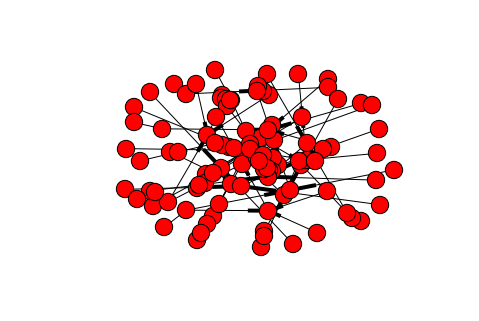

In [158]:
#Plotting the last graph obtained
nx.draw(G)
plt.show()

In [159]:
list_potential_friends

[[4, 10, 17, 18, 19, 38, 58, 64, 71, 83, 95],
 [2, 4, 13, 15, 23, 27, 44, 52, 57, 66, 68, 75, 77, 79, 88, 96],
 [5,
  9,
  15,
  23,
  38,
  39,
  42,
  48,
  52,
  55,
  56,
  57,
  58,
  61,
  63,
  72,
  74,
  77,
  78,
  79,
  86,
  88,
  89,
  97],
 [0,
  1,
  9,
  10,
  15,
  24,
  25,
  39,
  42,
  44,
  45,
  49,
  55,
  63,
  69,
  71,
  75,
  81,
  83,
  85,
  93,
  95,
  98,
  99],
 [5,
  6,
  9,
  14,
  19,
  22,
  23,
  24,
  29,
  31,
  32,
  38,
  50,
  55,
  65,
  75,
  77,
  78,
  79,
  80,
  92,
  95],
 [1, 3, 7, 14, 17, 20, 23, 37, 45, 46, 51, 56, 66, 69, 72, 77, 80, 84, 91, 98],
 [5,
  9,
  17,
  23,
  24,
  26,
  33,
  38,
  39,
  44,
  46,
  56,
  58,
  63,
  66,
  72,
  78,
  79,
  81,
  84,
  85,
  90,
  94,
  96,
  99],
 [8, 12, 17, 20, 25, 30, 31, 33, 45, 48, 55, 57, 60, 86, 92, 96],
 [4,
  10,
  12,
  14,
  25,
  27,
  35,
  36,
  39,
  43,
  53,
  55,
  57,
  62,
  66,
  67,
  72,
  73,
  77,
  80,
  82,
  85,
  90,
  96,
  98],
 [15, 16, 28, 40, 42, 48, 49,